# 04 — Econometrics: Granger Causality, VAR & Diebold-Yilmaz Spillover

Three parts:
1. **Granger Causality** — pairwise tests: does crypto predict TradFi (and vice versa)?
2. **VAR + Diebold-Yilmaz** — system-wide spillover table from FEVD
3. **Rolling Spillover** — total connectedness index over time

**Statistical notes**:
- All tests require stationary data. Log returns are typically I(0), but we verify with ADF.
- VIX is already a volatility measure, not a price — its returns represent changes in implied vol.
- Granger causality ≠ true causality. It tests predictive information content only.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from pathlib import Path

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR

warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.figsize': (14, 6),
    'figure.dpi': 100,
    'font.size': 11,
})

DATA_DIR = Path('..') / 'data'

## 0. Load Data & Define Groups

In [2]:
returns = pd.read_csv(DATA_DIR / 'returns.csv', index_col='Date', parse_dates=True)
events = pd.read_csv(DATA_DIR / 'events.csv', index_col=0, parse_dates=['start', 'end'])

TRADFI = ['Gold', 'NASDAQ 100', 'S&P 500', 'US Treasury 20Y+', 'US Dollar Index', 'VIX']
CRYPTO = ['Bitcoin', 'Ethereum', 'BNB', 'Solana', 'Aave (DeFi proxy)']

TRADFI = [c for c in TRADFI if c in returns.columns]
CRYPTO = [c for c in CRYPTO if c in returns.columns]
ALL_ASSETS = TRADFI + CRYPTO

# Short labels for display
SHORT = {
    'Gold': 'Gold', 'NASDAQ 100': 'NDX', 'S&P 500': 'SPX',
    'US Treasury 20Y+': 'TLT', 'US Dollar Index': 'USD', 'VIX': 'VIX',
    'Bitcoin': 'BTC', 'Ethereum': 'ETH', 'BNB': 'BNB',
    'Solana': 'SOL', 'Aave (DeFi proxy)': 'AAVE',
}

print(f'Loaded: {len(returns)} days, {len(ALL_ASSETS)} assets')
print(f'TradFi: {[SHORT[a] for a in TRADFI]}')
print(f'Crypto: {[SHORT[a] for a in CRYPTO]}')

Loaded: 1529 days, 11 assets
TradFi: ['Gold', 'NDX', 'SPX', 'TLT', 'USD', 'VIX']
Crypto: ['BTC', 'ETH', 'BNB', 'SOL', 'AAVE']


---
# Part 1 — Granger Causality

## 1.1 Stationarity Check (ADF Test)

Granger causality requires stationary series. Log returns should be I(0), but we verify.
If ADF p-value > 0.05, we take first differences (Δ returns).

In [3]:
def check_stationarity(series, name, significance=0.05):
    """
    Run Augmented Dickey-Fuller test on a series.
    
    Returns
    -------
    dict with keys: 'name', 'adf_stat', 'p_value', 'is_stationary', 'n_obs'
    """
    clean = series.dropna()
    if len(clean) < 20:
        return {'name': name, 'adf_stat': np.nan, 'p_value': np.nan,
                'is_stationary': False, 'n_obs': len(clean)}
    
    result = adfuller(clean, autolag='AIC')
    return {
        'name': name,
        'adf_stat': round(result[0], 4),
        'p_value': round(result[1], 6),
        'is_stationary': result[1] < significance,
        'n_obs': len(clean),
    }


# Run ADF on all assets
adf_results = []
for asset in ALL_ASSETS:
    adf_results.append(check_stationarity(returns[asset], SHORT[asset]))

adf_df = pd.DataFrame(adf_results).set_index('name')
display(adf_df)

non_stationary = adf_df[~adf_df['is_stationary']]
if len(non_stationary) > 0:
    print(f'\n⚠️  Non-stationary series: {list(non_stationary.index)}')
    print('   Will use first differences for these in Granger tests.')
else:
    print('\n✓ All series are stationary (as expected for log returns).')

,adf_stat,p_value,is_stationary,n_obs
name,,,,
Gold,-28.5592,0.0,True,1529
NDX,-12.0421,0.0,True,1529
SPX,-11.7147,0.0,True,1529
TLT,-7.4234,0.0,True,1529
USD,-17.4832,0.0,True,1529
VIX,-18.3260,0.0,True,1529
BTC,-14.1354,0.0,True,1529
ETH,-14.3703,0.0,True,1529
BNB,-11.4226,0.0,True,1529



✓ All series are stationary (as expected for log returns).


## 1.2 Granger Causality Tests

For every (crypto, tradfi) pair, test both directions:
- H₀: crypto does NOT Granger-cause tradfi
- H₀: tradfi does NOT Granger-cause crypto

We test lags 1–5 and select the optimal lag by minimum AIC.
Report the F-test p-value at the best lag.

In [4]:
def prepare_series_for_granger(returns_df, asset, adf_df, short_labels):
    """
    Return a clean series, differenced if non-stationary.
    """
    s = returns_df[asset].dropna()
    label = short_labels[asset]
    if label in adf_df.index and not adf_df.loc[label, 'is_stationary']:
        s = s.diff().dropna()
    return s


def run_granger_pair(y_series, x_series, max_lag=5):
    """
    Test if x Granger-causes y, for lags 1..max_lag.
    
    statsmodels convention: grangercausalitytests(data, maxlag)
    where data[:, 0] is the 'caused' (y) and data[:, 1] is the 'cause' (x).
    Tests H0: x does NOT Granger-cause y.
    
    Returns
    -------
    best_lag : int
    best_pvalue : float  (F-test p-value at best lag by minimum p-value)
    all_pvalues : dict {lag: p_value}
    """
    # Align the two series on common dates
    combined = pd.concat([y_series, x_series], axis=1).dropna()
    
    if len(combined) < max_lag + 20:
        return None, np.nan, {}
    
    data = combined.values  # column 0 = y (caused), column 1 = x (cause)
    
    try:
        result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
    except Exception:
        return None, np.nan, {}
    
    # Extract F-test p-values for each lag
    all_pvalues = {}
    for lag in range(1, max_lag + 1):
        # result[lag][0] is a dict of test results
        # 'ssr_ftest' returns (F-stat, p-value, df_denom, df_num)
        f_pvalue = result[lag][0]['ssr_ftest'][1]
        all_pvalues[lag] = f_pvalue
    
    # Best lag = the one with lowest p-value
    best_lag = min(all_pvalues, key=all_pvalues.get)
    best_pvalue = all_pvalues[best_lag]
    
    return best_lag, best_pvalue, all_pvalues


print('Granger test functions defined')

Granger test functions defined


In [5]:
# Run Granger tests for all (crypto, tradfi) pairs in both directions
MAX_LAG = 5
granger_rows = []

for crypto_asset in CRYPTO:
    crypto_s = prepare_series_for_granger(returns, crypto_asset, adf_df, SHORT)
    
    for tradfi_asset in TRADFI:
        tradfi_s = prepare_series_for_granger(returns, tradfi_asset, adf_df, SHORT)
        
        # Direction 1: Crypto → TradFi (does crypto predict tradfi?)
        # y=tradfi (caused), x=crypto (cause)
        lag1, pval1, _ = run_granger_pair(tradfi_s, crypto_s, max_lag=MAX_LAG)
        granger_rows.append({
            'cause': SHORT[crypto_asset],
            'effect': SHORT[tradfi_asset],
            'direction': 'Crypto → TradFi',
            'best_lag': lag1,
            'p_value': round(pval1, 4) if not np.isnan(pval1) else np.nan,
            'significant_5pct': pval1 < 0.05 if not np.isnan(pval1) else False,
        })
        
        # Direction 2: TradFi → Crypto (does tradfi predict crypto?)
        # y=crypto (caused), x=tradfi (cause)
        lag2, pval2, _ = run_granger_pair(crypto_s, tradfi_s, max_lag=MAX_LAG)
        granger_rows.append({
            'cause': SHORT[tradfi_asset],
            'effect': SHORT[crypto_asset],
            'direction': 'TradFi → Crypto',
            'best_lag': lag2,
            'p_value': round(pval2, 4) if not np.isnan(pval2) else np.nan,
            'significant_5pct': pval2 < 0.05 if not np.isnan(pval2) else False,
        })

granger_df = pd.DataFrame(granger_rows)

# Summary stats
n_total = len(granger_df.dropna(subset=['p_value']))
n_sig = granger_df['significant_5pct'].sum()
print(f'Tested {n_total} direction-pairs (lags 1-{MAX_LAG})')
print(f'Significant at 5%: {n_sig} / {n_total} ({100*n_sig/n_total:.1f}%)')
print()

# Show significant results
sig_df = granger_df[granger_df['significant_5pct']].sort_values('p_value')
print(f'=== Significant Granger-causal relationships ===')
display(sig_df[['cause', 'effect', 'direction', 'best_lag', 'p_value']])

Tested 60 direction-pairs (lags 1-5)
Significant at 5%: 16 / 60 (26.7%)

=== Significant Granger-causal relationships ===


,cause,effect,direction,best_lag,p_value
8,BTC,USD,Crypto → TradFi,4,0.0000
20,ETH,USD,Crypto → TradFi,4,0.0000
32,BNB,USD,Crypto → TradFi,4,0.0000
25,Gold,BNB,TradFi → Crypto,4,0.0004
18,ETH,TLT,Crypto → TradFi,2,0.0021
4,BTC,SPX,Crypto → TradFi,2,0.0094
6,BTC,TLT,Crypto → TradFi,2,0.0136
2,BTC,NDX,Crypto → TradFi,2,0.0140
16,ETH,SPX,Crypto → TradFi,2,0.0190
47,VIX,SOL,TradFi → Crypto,5,0.0321


## 1.3 Granger Causality Heatmaps

Two heatmaps:
- **Left**: Crypto → TradFi (crypto predicts tradfi?)
- **Right**: TradFi → Crypto (tradfi predicts crypto?)

Color = p-value (darker = more significant). Stars mark p < 0.05.

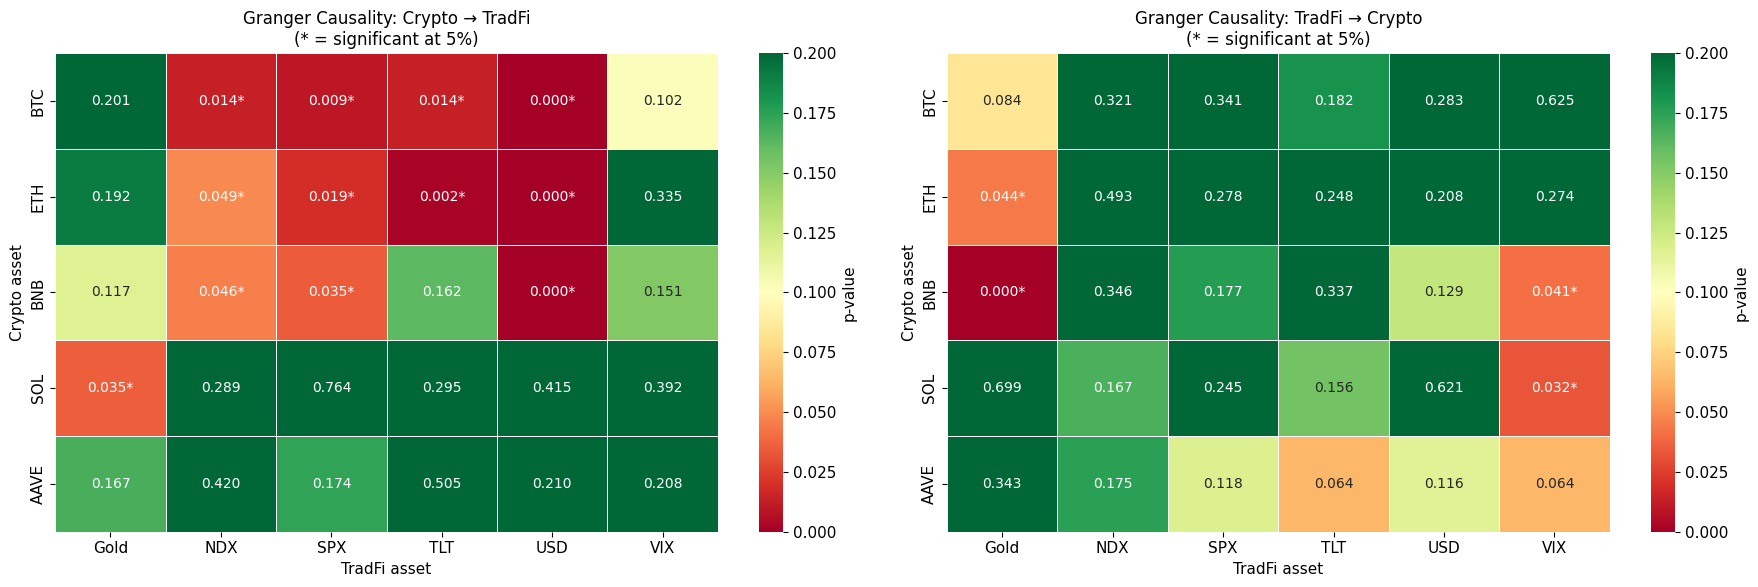

In [6]:
def build_granger_heatmap_data(granger_df, direction, crypto_labels, tradfi_labels):
    """
    Pivot Granger results into a matrix for heatmap plotting.
    
    For 'Crypto → TradFi': rows=crypto (cause), cols=tradfi (effect)
    For 'TradFi → Crypto': rows=crypto (effect), cols=tradfi (cause)
    
    Returns
    -------
    pval_matrix : pd.DataFrame  (rows=crypto, cols=tradfi, values=p_value)
    sig_matrix : pd.DataFrame   (same shape, boolean: significant?)
    """
    subset = granger_df[granger_df['direction'] == direction].copy()
    
    if direction == 'Crypto → TradFi':
        # cause=crypto, effect=tradfi
        pval_matrix = subset.pivot(index='cause', columns='effect', values='p_value')
        sig_matrix = subset.pivot(index='cause', columns='effect', values='significant_5pct')
    else:
        # cause=tradfi, effect=crypto
        pval_matrix = subset.pivot(index='effect', columns='cause', values='p_value')
        sig_matrix = subset.pivot(index='effect', columns='cause', values='significant_5pct')
    
    # Reorder rows=crypto, cols=tradfi
    pval_matrix = pval_matrix.reindex(index=crypto_labels, columns=tradfi_labels)
    sig_matrix = sig_matrix.reindex(index=crypto_labels, columns=tradfi_labels)
    
    return pval_matrix, sig_matrix


crypto_labels = [SHORT[c] for c in CRYPTO]
tradfi_labels = [SHORT[t] for t in TRADFI]

# Build matrices for both directions
pval_c2t, sig_c2t = build_granger_heatmap_data(granger_df, 'Crypto → TradFi',
                                                crypto_labels, tradfi_labels)
pval_t2c, sig_t2c = build_granger_heatmap_data(granger_df, 'TradFi → Crypto',
                                                crypto_labels, tradfi_labels)

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

for ax, pval_mat, sig_mat, title in [
    (ax1, pval_c2t, sig_c2t, 'Crypto → TradFi'),
    (ax2, pval_t2c, sig_t2c, 'TradFi → Crypto'),
]:
    # Annotation: show p-value with star if significant
    annot_text = pval_mat.copy().astype(str)
    for i in range(pval_mat.shape[0]):
        for j in range(pval_mat.shape[1]):
            val = pval_mat.iloc[i, j]
            is_sig = sig_mat.iloc[i, j]
            if pd.isna(val):
                annot_text.iloc[i, j] = '—'
            else:
                star = '*' if is_sig else ''
                annot_text.iloc[i, j] = f'{val:.3f}{star}'
    
    sns.heatmap(
        pval_mat,
        annot=annot_text,
        fmt='',
        cmap='RdYlGn',  # green=low p-value (significant), red=high
        vmin=0, vmax=0.2,
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'p-value'},
        annot_kws={'size': 10},
    )
    ax.set_title(f'Granger Causality: {title}\n(* = significant at 5%)', fontsize=12)
    ax.set_ylabel('Crypto asset' if 'Crypto' in title.split('→')[0].strip() else 'Crypto asset')
    ax.set_xlabel('TradFi asset')

plt.tight_layout()
plt.savefig(DATA_DIR / 'granger_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 2 — VAR & Diebold-Yilmaz Spillover Index

## 2.1 Prepare Data for VAR

VAR requires a balanced panel (no NaN). We use the common sample period where all assets have data. For assets that start later (Aave: Oct 2020, Solana: Apr 2020), we trim to the latest start date.

In [7]:
# Find the common sample: latest first_valid_index across all assets
first_dates = {asset: returns[asset].first_valid_index() for asset in ALL_ASSETS}
common_start = max(first_dates.values())

# Trim returns to common sample, drop any remaining NaN rows
var_data = returns.loc[common_start:, ALL_ASSETS].dropna()

print(f'Common sample start: {common_start.date()}')
print(f'VAR data shape: {var_data.shape} ({var_data.shape[0]} obs x {var_data.shape[1]} assets)')
print(f'Date range: {var_data.index[0].date()} to {var_data.index[-1].date()}')
print(f'\nAny NaN remaining: {var_data.isna().any().any()}')

Common sample start: 2020-10-05
VAR data shape: (1087, 11) (1087 obs x 11 assets)
Date range: 2020-10-05 to 2025-01-31

Any NaN remaining: False


## 2.2 Fit VAR Model (Optimal Lag by AIC)

In [8]:
def fit_var_model(data, max_lag=10, min_lag=1):
    """
    Fit a VAR model and select optimal lag order by AIC.
    
    Parameters
    ----------
    data : pd.DataFrame
        Stationary, balanced panel of returns.
    max_lag : int
        Maximum lag to consider.
    min_lag : int
        Minimum lag (must be >= 1 for meaningful dynamics/FEVD).
    
    Returns
    -------
    var_result : VARResults
    best_lag : int
    """
    model = VAR(data)
    
    # Manual AIC comparison for lags min_lag..max_lag
    # (select_order can return 0, which breaks FEVD)
    aic_values = {}
    for lag in range(min_lag, max_lag + 1):
        try:
            result = model.fit(lag)
            aic_values[lag] = result.aic
        except Exception:
            pass
    
    # Display AIC table
    aic_df = pd.DataFrame({
        'lag': list(aic_values.keys()),
        'AIC': [round(v, 4) for v in aic_values.values()]
    }).set_index('lag')
    print('Lag selection by AIC (lower = better):')
    display(aic_df.T)
    
    best_lag = min(aic_values, key=aic_values.get)
    print(f'\nOptimal lag by AIC: {best_lag} (enforced min_lag={min_lag})')
    
    # Fit at optimal lag
    var_result = model.fit(best_lag)
    print(f'Fitted VAR({best_lag}): {var_result.nobs} observations, '
          f'{var_result.k_ar} lags, {var_result.neqs} equations')
    
    return var_result, best_lag


var_result, best_lag = fit_var_model(var_data, max_lag=10, min_lag=1)

Lag selection by AIC (lower = better):


lag,1,2,3,4,5,6,7,8,9,10
AIC,-87.5438,-87.5056,-87.4222,-87.3584,-87.2776,-87.2256,-87.0953,-86.9984,-86.9143,-86.869



Optimal lag by AIC: 1 (enforced min_lag=1)
Fitted VAR(1): 1086 observations, 1 lags, 11 equations


## 2.3 Forecast Error Variance Decomposition (FEVD)

FEVD tells us: for each asset, what fraction of its forecast error variance at horizon h is explained by shocks to each other asset?

This is the building block for the Diebold-Yilmaz spillover table.

In [9]:
def compute_fevd_table(var_result, horizon=10):
    """
    Compute FEVD at a given horizon and return as a DataFrame.
    
    Returns
    -------
    fevd_df : pd.DataFrame
        Shape (n_assets, n_assets). Entry [i, j] = fraction of asset i's
        forecast error variance explained by shocks to asset j, at horizon h.
        Rows sum to 1.0.
    """
    fevd = var_result.fevd(horizon)
    
    # fevd.decomp shape depends on statsmodels version:
    #   older: (n_vars, horizon, n_vars)
    #   newer: (horizon, n_vars, n_vars)
    decomp = fevd.decomp
    print(f'  FEVD decomp raw shape: {decomp.shape}')
    
    n_vars = var_result.neqs
    
    # Detect shape convention and extract the last horizon step
    if decomp.shape[0] == n_vars and decomp.shape[1] == horizon:
        # Shape: (n_vars, horizon, n_vars) — older convention
        # decomp[i, h, j] = fraction of var_i at step h from shock_j
        last_step = decomp[:, horizon - 1, :]  # shape (n_vars, n_vars)
    elif decomp.shape[0] == horizon and decomp.shape[1] == n_vars:
        # Shape: (horizon, n_vars, n_vars) — newer convention
        last_step = decomp[horizon - 1]  # shape (n_vars, n_vars)
    else:
        raise ValueError(f'Unexpected FEVD decomp shape: {decomp.shape}')
    
    asset_names = var_result.names
    fevd_df = pd.DataFrame(last_step, index=asset_names, columns=asset_names)
    
    return fevd_df


HORIZON = 10
fevd_df = compute_fevd_table(var_result, horizon=HORIZON)

print(f'FEVD at horizon {HORIZON} days')
print(f'Row sums (should be ~1.0): {fevd_df.sum(axis=1).round(3).values}')
print()

# Display with short labels
fevd_display = fevd_df.copy()
fevd_display.index = [SHORT.get(n, n) for n in fevd_display.index]
fevd_display.columns = [SHORT.get(n, n) for n in fevd_display.columns]
display(fevd_display.round(3))

  FEVD decomp raw shape: (11, 10, 11)
FEVD at horizon 10 days
Row sums (should be ~1.0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



,Gold,NDX,SPX,TLT,USD,VIX,BTC,ETH,BNB,SOL,AAVE
Gold,0.986,0.001,0.000,0.000,0.005,0.000,0.000,0.001,0.003,0.004,0.000
NDX,0.024,0.966,0.000,0.000,0.001,0.001,0.000,0.003,0.003,0.003,0.000
SPX,0.026,0.835,0.127,0.000,0.001,0.001,0.000,0.004,0.002,0.002,0.000
TLT,0.086,0.005,0.013,0.889,0.001,0.002,0.001,0.000,0.002,0.001,0.000
USD,0.231,0.078,0.023,0.021,0.642,0.001,0.000,0.000,0.000,0.003,0.000
VIX,0.015,0.430,0.093,0.002,0.001,0.456,0.000,0.001,0.002,0.001,0.000
BTC,0.005,0.128,0.004,0.001,0.003,0.006,0.845,0.001,0.000,0.007,0.000
ETH,0.007,0.112,0.005,0.002,0.005,0.007,0.517,0.338,0.001,0.004,0.000
BNB,0.003,0.075,0.001,0.001,0.004,0.003,0.334,0.067,0.509,0.004,0.000
SOL,0.006,0.090,0.006,0.002,0.004,0.001,0.233,0.082,0.026,0.551,0.001


## 2.4 Diebold-Yilmaz Spillover Table

The DY framework (Diebold & Yilmaz, 2012) normalizes FEVD rows and computes:
- **"FROM others"** — how much of asset i's variance comes from shocks to all other assets
- **"TO others"** — how much asset i's shocks contribute to the variance of all other assets
- **"NET"** = TO - FROM (net transmitter if positive, net receiver if negative)
- **Total Spillover Index** = sum of cross-variable spillovers / N

In [10]:
def diebold_yilmaz_table(fevd_df):
    """
    Build the Diebold-Yilmaz spillover table from FEVD.
    
    The FEVD matrix is already row-normalized (rows sum to 1).
    We convert to percentages for readability.
    
    Returns
    -------
    spillover_table : pd.DataFrame
        Full DY table with 'FROM_others' row and 'TO_others' column.
    directional : pd.DataFrame
        Per-asset: FROM, TO, NET spillovers.
    total_spillover : float
        Total Spillover Index (%).
    """
    n = len(fevd_df)
    assets = fevd_df.index.tolist()
    
    # Convert to percentages
    pct = fevd_df * 100
    
    # "FROM others": for each asset i, sum of off-diagonal elements in row i
    from_others = pd.Series(
        [pct.iloc[i].sum() - pct.iloc[i, i] for i in range(n)],
        index=assets, name='FROM_others'
    )
    
    # "TO others": for each asset j, sum of off-diagonal elements in column j
    to_others = pd.Series(
        [pct.iloc[:, j].sum() - pct.iloc[j, j] for j in range(n)],
        index=assets, name='TO_others'
    )
    
    # NET = TO - FROM
    net = to_others - from_others
    net.name = 'NET'
    
    # Total Spillover Index = sum(FROM_others) / N
    total_spillover = from_others.sum() / n
    
    # Build the full table
    spillover_table = pct.copy()
    spillover_table['FROM_others'] = from_others
    
    # Add TO_others as a bottom row
    to_row = to_others.to_frame().T
    to_row.index = ['TO_others']
    to_row['FROM_others'] = total_spillover  # total in corner cell
    spillover_table = pd.concat([spillover_table, to_row])
    
    # Directional summary
    directional = pd.DataFrame({
        'FROM_others': from_others,
        'TO_others': to_others,
        'NET': net,
    })
    
    return spillover_table, directional, total_spillover


spill_table, directional, total_spill = diebold_yilmaz_table(fevd_df)

# Display with short labels
st_display = spill_table.copy()
st_display.index = [SHORT.get(n, n) for n in st_display.index]
st_display.columns = [SHORT.get(n, n) for n in st_display.columns]

print(f'=== Diebold-Yilmaz Spillover Table (horizon={HORIZON}, %) ===')
display(st_display.round(2))
print(f'\nTotal Spillover Index: {total_spill:.2f}%')

=== Diebold-Yilmaz Spillover Table (horizon=10, %) ===


,Gold,NDX,SPX,TLT,USD,VIX,BTC,ETH,BNB,SOL,AAVE,FROM_others
Gold,98.60,0.10,0.01,0.03,0.49,0.04,0.00,0.07,0.25,0.38,0.01,1.40
NDX,2.36,96.56,0.00,0.00,0.06,0.11,0.00,0.28,0.28,0.34,0.01,3.44
SPX,2.64,83.51,12.73,0.01,0.08,0.13,0.05,0.43,0.21,0.21,0.01,87.27
TLT,8.57,0.54,1.35,88.90,0.07,0.20,0.09,0.01,0.16,0.11,0.00,11.10
USD,23.12,7.83,2.27,2.09,64.23,0.08,0.00,0.05,0.01,0.32,0.00,35.77
VIX,1.54,43.00,9.28,0.16,0.13,45.56,0.00,0.05,0.19,0.08,0.00,54.44
BTC,0.54,12.78,0.36,0.10,0.31,0.56,84.53,0.11,0.04,0.67,0.00,15.47
ETH,0.75,11.24,0.52,0.24,0.53,0.68,51.73,33.79,0.13,0.38,0.00,66.21
BNB,0.33,7.47,0.14,0.09,0.36,0.26,33.35,6.67,50.90,0.43,0.01,49.10
SOL,0.56,8.97,0.61,0.18,0.41,0.07,23.29,8.20,2.61,55.06,0.05,44.94



Total Spillover Index: 38.69%


## 2.5 Directional Spillovers: Bar Chart

,FROM_others,TO_others,NET
Gold,1.40,40.72,39.32
NDX,3.44,185.03,181.59
SPX,87.27,15.72,-71.56
TLT,11.10,2.98,-8.12
USD,35.77,2.68,-33.09
VIX,54.44,2.67,-51.77
BTC,15.47,134.71,119.24
ETH,66.21,30.27,-35.94
BNB,49.10,5.11,-43.99
SOL,44.94,5.62,-39.32


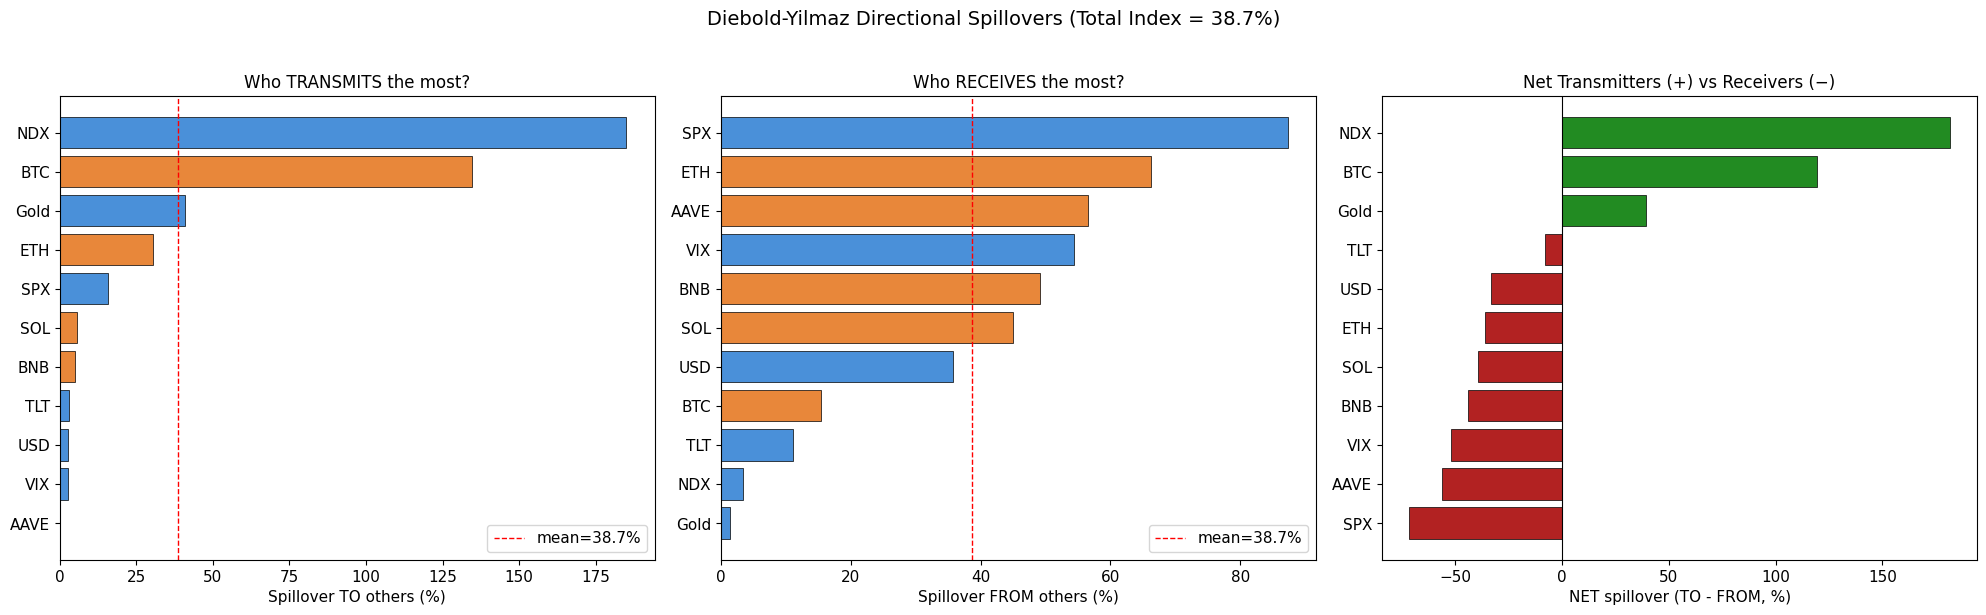

In [11]:
dir_display = directional.copy()
dir_display.index = [SHORT.get(n, n) for n in dir_display.index]
display(dir_display.round(2))

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- TO others ---
ax = axes[0]
to_sorted = dir_display['TO_others'].sort_values(ascending=True)
colors_to = ['#E8873A' if SHORT.get(n, n) in [SHORT[c] for c in CRYPTO] else '#4A90D9'
             for n in to_sorted.index]
# Fix: compare labels directly since index is already short labels
crypto_short = [SHORT[c] for c in CRYPTO]
colors_to = ['#E8873A' if n in crypto_short else '#4A90D9' for n in to_sorted.index]
ax.barh(to_sorted.index, to_sorted.values, color=colors_to, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Spillover TO others (%)')
ax.set_title('Who TRANSMITS the most?', fontsize=12)
ax.axvline(x=to_sorted.mean(), color='red', linestyle='--', linewidth=1, label=f'mean={to_sorted.mean():.1f}%')
ax.legend()

# --- FROM others ---
ax = axes[1]
from_sorted = dir_display['FROM_others'].sort_values(ascending=True)
colors_from = ['#E8873A' if n in crypto_short else '#4A90D9' for n in from_sorted.index]
ax.barh(from_sorted.index, from_sorted.values, color=colors_from, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Spillover FROM others (%)')
ax.set_title('Who RECEIVES the most?', fontsize=12)
ax.axvline(x=from_sorted.mean(), color='red', linestyle='--', linewidth=1, label=f'mean={from_sorted.mean():.1f}%')
ax.legend()

# --- NET ---
ax = axes[2]
net_sorted = dir_display['NET'].sort_values(ascending=True)
colors_net = ['firebrick' if v < 0 else 'forestgreen' for v in net_sorted.values]
ax.barh(net_sorted.index, net_sorted.values, color=colors_net, edgecolor='black', linewidth=0.5)
ax.set_xlabel('NET spillover (TO - FROM, %)')
ax.set_title('Net Transmitters (+) vs Receivers (−)', fontsize=12)
ax.axvline(x=0, color='black', linewidth=0.8)

fig.suptitle(f'Diebold-Yilmaz Directional Spillovers (Total Index = {total_spill:.1f}%)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(DATA_DIR / 'spillover_directional.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 3 — Rolling Spillover Index

## 3.1 Rolling Total Spillover (200-day window)

For each rolling window, fit a VAR and compute the DY total spillover index.
This traces how systemic connectedness evolves over time.

**Note**: This is computationally intensive (~1000+ VAR fits). We use the same lag order throughout for consistency (the lag selected above).

In [12]:
def compute_rolling_spillover(data, window=200, var_lag=2, horizon=10, step=5):
    """
    Compute the Diebold-Yilmaz total spillover index in a rolling window.
    
    Parameters
    ----------
    data : pd.DataFrame
        Balanced panel of returns.
    window : int
        Rolling window size (trading days).
    var_lag : int
        Lag order for VAR (fixed across windows for consistency).
    horizon : int
        FEVD forecast horizon.
    step : int
        Step size between windows (to speed up computation).
        step=1 means every day, step=5 means every week.
    
    Returns
    -------
    spillover_ts : pd.Series
        Total spillover index at each window end date.
    """
    dates = data.index
    n = len(data)
    n_vars = data.shape[1]
    
    results = []
    n_success = 0
    n_fail = 0
    
    for end_idx in range(window, n, step):
        start_idx = end_idx - window
        window_data = data.iloc[start_idx:end_idx]
        end_date = dates[end_idx - 1]
        
        try:
            model = VAR(window_data)
            var_fit = model.fit(var_lag)
            fevd = var_fit.fevd(horizon)
            decomp = fevd.decomp
            
            # Handle both shape conventions
            if decomp.shape[0] == n_vars and decomp.shape[1] == horizon:
                last_step = decomp[:, horizon - 1, :]
            elif decomp.shape[0] == horizon and decomp.shape[1] == n_vars:
                last_step = decomp[horizon - 1]
            else:
                n_fail += 1
                continue
            
            # Total spillover = sum of off-diagonal / N * 100
            off_diag_sum = last_step.sum() - np.trace(last_step)
            total_spill = (off_diag_sum / n_vars) * 100
            
            results.append((end_date, total_spill))
            n_success += 1
        except Exception:
            n_fail += 1
            continue
    
    print(f'Rolling spillover: {n_success} windows computed, {n_fail} failed')
    
    if not results:
        return pd.Series(dtype=float)
    
    spillover_ts = pd.Series(
        [r[1] for r in results],
        index=[r[0] for r in results],
        name='Total Spillover Index'
    )
    
    return spillover_ts


ROLL_WINDOW = 200
ROLL_STEP = 5  # every 5 trading days (~weekly) to keep it fast

print(f'Computing rolling spillover (window={ROLL_WINDOW}, step={ROLL_STEP}, '
      f'lag={best_lag}, horizon={HORIZON})...')
print(f'Expected windows: ~{(len(var_data) - ROLL_WINDOW) // ROLL_STEP}')

rolling_spill = compute_rolling_spillover(
    var_data, window=ROLL_WINDOW, var_lag=best_lag,
    horizon=HORIZON, step=ROLL_STEP
)

Computing rolling spillover (window=200, step=5, lag=1, horizon=10)...
Expected windows: ~177


Rolling spillover: 178 windows computed, 0 failed


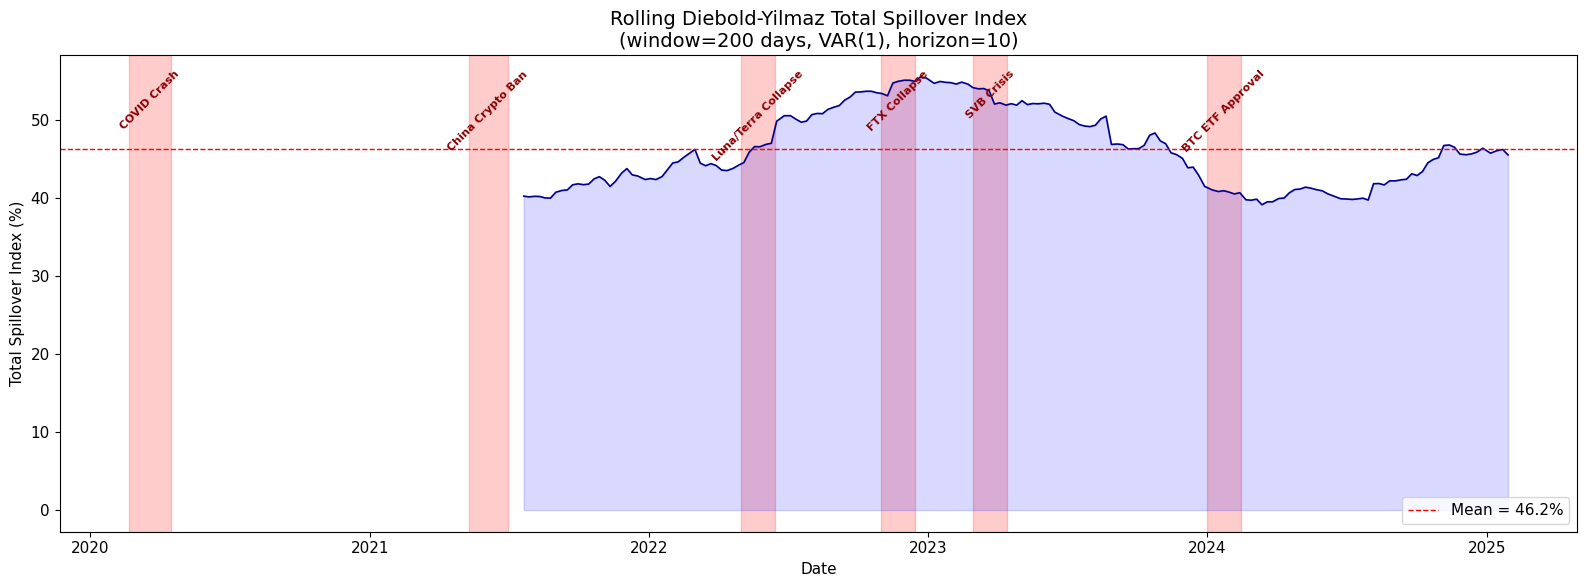


Spillover statistics:
  Mean:   46.2%
  Std:    5.0%
  Min:    39.1% (2024-03-13)
  Max:    55.5% (2022-12-22)


In [13]:
# --- Plot rolling spillover with crisis events ---
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(rolling_spill.index, rolling_spill.values,
        color='darkblue', linewidth=1.2)
ax.fill_between(rolling_spill.index, rolling_spill.values,
                alpha=0.15, color='blue')

# Shade and label crisis events
for event_name, row in events.iterrows():
    ax.axvspan(row['start'], row['end'], alpha=0.20, color='red', zorder=0)
    mid = row['start'] + (row['end'] - row['start']) / 2
    ax.text(mid, ax.get_ylim()[1] * 0.97 if ax.get_ylim()[1] > 0 else 50,
            event_name, ha='center', va='top', fontsize=8,
            rotation=45, color='darkred', fontweight='bold')

ax.set_title(f'Rolling Diebold-Yilmaz Total Spillover Index\n'
             f'(window={ROLL_WINDOW} days, VAR({best_lag}), horizon={HORIZON})',
             fontsize=14)
ax.set_ylabel('Total Spillover Index (%)')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add horizontal line for mean
mean_spill = rolling_spill.mean()
ax.axhline(y=mean_spill, color='red', linestyle='--', linewidth=1,
           label=f'Mean = {mean_spill:.1f}%')
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig(DATA_DIR / 'rolling_spillover.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSpillover statistics:')
print(f'  Mean:   {rolling_spill.mean():.1f}%')
print(f'  Std:    {rolling_spill.std():.1f}%')
print(f'  Min:    {rolling_spill.min():.1f}% ({rolling_spill.idxmin().date()})')
print(f'  Max:    {rolling_spill.max():.1f}% ({rolling_spill.idxmax().date()})')